In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.8 MB/s eta 0:00:00


CO₂ Rotational Hamiltonian VQE Calculation
Maximum J: 3
Basis size: 16
Rotational constant B: 0.39 cm⁻¹
Centrifugal distortion D: 4e-07 cm⁻¹

Building CO₂ rotational Hamiltonian...
Basis states:
  |0⟩ = |J=0, M_J=0⟩
  |1⟩ = |J=1, M_J=-1⟩
  |2⟩ = |J=1, M_J=0⟩
  |3⟩ = |J=1, M_J=1⟩
  |4⟩ = |J=2, M_J=-2⟩
  |5⟩ = |J=2, M_J=-1⟩
  |6⟩ = |J=2, M_J=0⟩
  |7⟩ = |J=2, M_J=1⟩
  |8⟩ = |J=2, M_J=2⟩
  |9⟩ = |J=3, M_J=-3⟩
  |10⟩ = |J=3, M_J=-2⟩
  |11⟩ = |J=3, M_J=-1⟩
  |12⟩ = |J=3, M_J=0⟩
  |13⟩ = |J=3, M_J=1⟩
  |14⟩ = |J=3, M_J=2⟩
  |15⟩ = |J=3, M_J=3⟩

Converting to qubit Hamiltonian...
Number of qubits required: 4
Number of Pauli terms: 16

Computing classical eigenvalues...
Classical eigenvalues (cm⁻¹):
  E_0 = 0.000000
  E_1 = 0.779998
  E_2 = 0.779998
  E_3 = 0.779998
  E_4 = 2.339986
  E_5 = 2.339986
  E_6 = 2.339986
  E_7 = 2.339986
  E_8 = 2.339986
  E_9 = 4.679942
  E_10 = 4.679942
  E_11 = 4.679942
  E_12 = 4.679942
  E_13 = 4.679942
  E_14 = 4.679942
  E_15 = 4.679942

Solving using VQE...


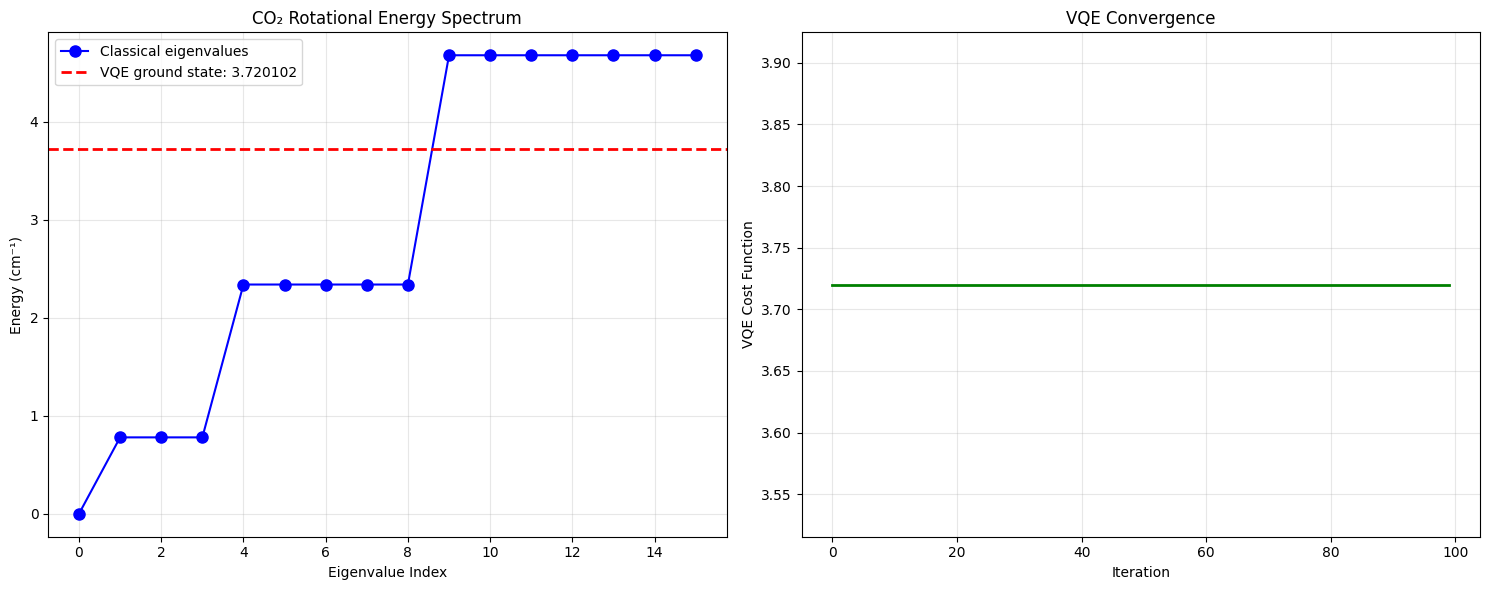


Rotational level analysis:
J=0: E = 0 cm⁻¹ (ground state)
J=1: E = 0.780000 cm⁻¹
J=2: E = 2.340000 cm⁻¹
J=3: E = 4.680000 cm⁻¹


In [7]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as pnp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import warnings
warnings.filterwarnings('ignore')

# Physical constants and parameters for CO2
class CO2Parameters:
    def __init__(self):
        # Rotational constants for CO2 (in cm^-1)
        self.B = 0.39  # Rotational constant
        self.D = 4.0e-7  # Centrifugal distortion constant
        self.max_J = 3  # Maximum J quantum number to consider

    def get_basis_size(self):
        """Calculate the size of the rotational basis"""
        # For linear molecules, each J has 2J+1 M_J states
        # But we'll work in the |J,M_J> basis
        return sum(2*J + 1 for J in range(self.max_J + 1))

def build_co2_hamiltonian(params):
    """
    Build the CO2 rotational Hamiltonian in the |J,M_J> basis
    H = B*J(J+1) - D*[J(J+1)]^2
    """
    basis_size = params.get_basis_size()
    H = np.zeros((basis_size, basis_size))

    # Create basis state mapping
    basis_states = []
    for J in range(params.max_J + 1):
        for M_J in range(-J, J + 1):
            basis_states.append((J, M_J))

    # Fill the Hamiltonian matrix
    for i, (J, M_J) in enumerate(basis_states):
        # Diagonal terms: B*J(J+1) - D*[J(J+1)]^2
        H[i, i] = params.B * J * (J + 1) - params.D * (J * (J + 1))**2

    return H, basis_states

def hamiltonian_to_pauli(H):
    """
    Convert a Hamiltonian matrix to Pauli operators representation
    """
    n_qubits = int(np.ceil(np.log2(H.shape[0])))

    # Pad the Hamiltonian to the nearest power of 2
    padded_size = 2**n_qubits
    H_padded = np.zeros((padded_size, padded_size), dtype=complex)
    H_padded[:H.shape[0], :H.shape[1]] = H

    # Convert to PennyLane Hamiltonian
    coeffs = []
    observables = []

    # Generate all possible Pauli strings
    pauli_ops = ['I', 'X', 'Y', 'Z']

    for pauli_indices in np.ndindex(*[4]*n_qubits):
        # Create Pauli operator
        pauli_matrices = []
        pauli_string = ""

        for i, pauli_idx in enumerate(pauli_indices):
            pauli_string += pauli_ops[pauli_idx]
            if pauli_ops[pauli_idx] == 'I':
                pauli_matrices.append(np.eye(2))
            elif pauli_ops[pauli_idx] == 'X':
                pauli_matrices.append(np.array([[0, 1], [1, 0]]))
            elif pauli_ops[pauli_idx] == 'Y':
                pauli_matrices.append(np.array([[0, -1j], [1j, 0]]))
            elif pauli_ops[pauli_idx] == 'Z':
                pauli_matrices.append(np.array([[1, 0], [0, -1]]))

        # Compute tensor product
        pauli_op = pauli_matrices[0]
        for mat in pauli_matrices[1:]:
            pauli_op = np.kron(pauli_op, mat)

        # Compute coefficient
        coeff = np.trace(H_padded @ pauli_op) / padded_size

        if abs(coeff) > 1e-10:  # Only keep non-zero coefficients
            coeffs.append(coeff.real)
            # Create PennyLane observable
            obs_list = []
            for i, pauli_char in enumerate(pauli_string):
                if pauli_char != 'I':
                    if pauli_char == 'X':
                        obs_list.append(qml.PauliX(i))
                    elif pauli_char == 'Y':
                        obs_list.append(qml.PauliY(i))
                    elif pauli_char == 'Z':
                        obs_list.append(qml.PauliZ(i))

            if obs_list:
                if len(obs_list) == 1:
                    observables.append(obs_list[0])
                else:
                    observables.append(qml.prod(*obs_list))
            else:
                observables.append(qml.Identity(0))

    return qml.Hamiltonian(coeffs, observables), n_qubits

def create_ansatz(params, n_qubits):
    """
    Create a variational ansatz for the VQE
    """
    # Use a simple hardware-efficient ansatz
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    for i in range(n_qubits):
        qml.RY(params[n_qubits + i], wires=i)

def solve_vqe(hamiltonian, n_qubits, max_iterations=100):
    """
    Solve the VQE problem
    """
    # Create device
    dev = qml.device("default.qubit", wires=n_qubits)

    # Create the cost function
    @qml.qnode(dev)
    def cost_function(params):
        create_ansatz(params, n_qubits)
        return qml.expval(hamiltonian)

    # Initialize parameters
    np.random.seed(42)
    params = np.random.uniform(0, 2*np.pi, 2*n_qubits)

    # Optimize
    optimizer = qml.AdamOptimizer(stepsize=0.1)

    costs = []
    for i in range(max_iterations):
        params, cost = optimizer.step_and_cost(cost_function, params)
        costs.append(cost)

        if i % 20 == 0:
            print(f"Iteration {i}: Cost = {cost:.6f}")

    return params, costs

def get_classical_spectrum(H, n_eigenvalues=None):
    """
    Get the classical eigenvalues for comparison
    """
    if n_eigenvalues is None:
        eigenvalues = np.linalg.eigvals(H)
    else:
        eigenvalues = eigsh(csr_matrix(H), k=min(n_eigenvalues, H.shape[0]-1),
                           which='SA', return_eigenvectors=False)

    return np.sort(eigenvalues)

def plot_spectrum_comparison(classical_energies, vqe_energy, costs):
    """
    Plot the energy spectrum and VQE convergence
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Energy spectrum
    ax1.plot(range(len(classical_energies)), classical_energies, 'bo-',
             label='Classical eigenvalues', markersize=8)
    ax1.axhline(y=vqe_energy, color='r', linestyle='--', linewidth=2,
                label=f'VQE ground state: {vqe_energy:.6f}')
    ax1.set_xlabel('Eigenvalue Index')
    ax1.set_ylabel('Energy (cm⁻¹)')
    ax1.set_title('CO₂ Rotational Energy Spectrum')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: VQE convergence
    ax2.plot(costs, 'g-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('VQE Cost Function')
    ax2.set_title('VQE Convergence')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to run the CO2 VQE calculation
    """
    print("CO₂ Rotational Hamiltonian VQE Calculation")
    print("=" * 50)

    # Initialize parameters
    params = CO2Parameters()
    print(f"Maximum J: {params.max_J}")
    print(f"Basis size: {params.get_basis_size()}")
    print(f"Rotational constant B: {params.B} cm⁻¹")
    print(f"Centrifugal distortion D: {params.D} cm⁻¹")

    # Build the molecular Hamiltonian
    print("\nBuilding CO₂ rotational Hamiltonian...")
    H_mol, basis_states = build_co2_hamiltonian(params)

    print("Basis states:")
    for i, (J, M_J) in enumerate(basis_states):
        print(f"  |{i}⟩ = |J={J}, M_J={M_J}⟩")

    # Convert to qubit Hamiltonian
    print("\nConverting to qubit Hamiltonian...")
    H_qubit, n_qubits = hamiltonian_to_pauli(H_mol)
    print(f"Number of qubits required: {n_qubits}")
    print(f"Number of Pauli terms: {len(H_qubit.coeffs)}")

    # Get classical spectrum for comparison
    print("\nComputing classical eigenvalues...")
    classical_energies = get_classical_spectrum(H_mol)
    print("Classical eigenvalues (cm⁻¹):")
    for i, energy in enumerate(classical_energies):
        print(f"  E_{i} = {energy:.6f}")

    # Solve using VQE
    print(f"\nSolving using VQE...")
    print("This may take a moment...")
    optimal_params, costs = solve_vqe(H_qubit, n_qubits)

    vqe_energy = costs[-1]
    print(f"\nVQE Results:")
    print(f"Ground state energy: {vqe_energy:.6f} cm⁻¹")
    print(f"Classical ground state: {classical_energies[0]:.6f} cm⁻¹")
    print(f"Error: {abs(vqe_energy - classical_energies[0]):.6f} cm⁻¹")

    # Plot results
    print("\nPlotting results...")
    plot_spectrum_comparison(classical_energies, vqe_energy, costs)

    # Additional analysis
    print("\nRotational level analysis:")
    print("J=0: E = 0 cm⁻¹ (ground state)")
    if params.max_J >= 1:
        print(f"J=1: E = {2*params.B:.6f} cm⁻¹")
    if params.max_J >= 2:
        print(f"J=2: E = {6*params.B:.6f} cm⁻¹")
    if params.max_J >= 3:
        print(f"J=3: E = {12*params.B:.6f} cm⁻¹")

if __name__ == "__main__":
    main()